In [146]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer

import gensim, logging, warnings
import gensim.corpora as corpora
from gensim import corpora, models
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [103]:
stop_words.extend(['look', 'smell', 'taste', 'feel', 'overall', 'rdev', 'beer', 'beers','nice','adams', 'jan', 'feb', 'mar',
                  'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'ml', 'oz', 'date'])

In [29]:
lemmatizer = WordNetLemmatizer()

## Import current data into pandas, reset the index

In [2]:
df = pd.read_csv('initial_df.csv', index_col = 0)
df = df.reset_index(drop=True)

In [11]:
df.head()

,abv,avail,avg_score,ba_score,brewery,img,location,name,no_ratings,no_reviews,review,style,url,taste_avg,look_avg,smell_avg,feel_avg
0,5.6,Winter,3.60,82.0,Boston Beer Company (Samuel Adams),https://cdn.beeradvocate.com/im/beers/101.jpg,Massachusetts,Samuel Adams Winter Lager,6210,2048,['3.31/5\xa0\xa0rDev -8.1%look: 4 | smell: 3.5...,German Bock,https://www.beeradvocate.com/beer/profile/35/101/,3.56,3.76,3.48,3.48
1,4.4,Year-round,3.19,73.0,Spoetzl Brewery,https://cdn.beeradvocate.com/im/beers/101.jpg,Texas,Shiner Bock,4331,1163,"[""3.19/5\xa0\xa0rDev 0%look: 3.75 | smell: 2.7...",German Bock,https://www.beeradvocate.com/beer/profile/143/...,3.47,3.76,3.31,3.31
2,5.8,Rotating,3.66,83.0,Boston Beer Company (Samuel Adams),https://cdn.beeradvocate.com/im/beers/101.jpg,Massachusetts,Samuel Adams Chocolate Bock,3101,1225,['3.78/5\xa0\xa0rDev +3.3%look: 3.75 | smell: ...,German Bock,https://www.beeradvocate.com/beer/profile/35/1...,3.65,3.64,3.59,3.59
3,5.2,Year-round,2.89,68.0,Anheuser-Busch,https://cdn.beeradvocate.com/im/beers/101.jpg,Missouri,Michelob AmberBock,1906,707,"[""3.09/5\xa0\xa0rDev +6.9%look: 3.5 | smell: 2...",German Bock,https://www.beeradvocate.com/beer/profile/29/1...,3.24,3.62,3.27,3.27
4,5.8,Rotating,3.50,80.0,Boston Beer Company (Samuel Adams),https://cdn.beeradvocate.com/im/beers/101.jpg,Massachusetts,Samuel Adams Cherry Chocolate Bock,873,187,['3/5\xa0\xa0rDev -14.3%look: 3 | smell: 3 | t...,German Bock,https://www.beeradvocate.com/beer/profile/35/6...,3.28,3.69,3.62,3.62


In [96]:
df.loc[0, 'review']

'[\'3.31/5\\xa0\\xa0rDev -8.1%look: 4 | smell: 3.5 | taste: 3 | feel: 3.25 | overall: 3.5Alright - this is one of those ‘it depends’ beers. Great deep copper, molasses color and pours with a brief head. Nice mouth feel with a good swallow. LET IT WARM UP A BIT is my best advice. Doesn’t do much when super cold, but a nice bread malt aroma...maybe a touch of spice is in there if you give it a chance. Not over the top and a reasonable bock buuuut a touch of hops may set some people off. I like this beer with dinner when I’m out eating warm, winter comfort food. Not a 4-5 range beer to buy to take home but a nice beverage on a cold night out.\\xa0566 charactersWilliamGustin, Yesterday at 11:04 PM\', \'2.74/5\\xa0\\xa0rDev -23.9%look: 3.5 | smell: 2.5 | taste: 2.75 | feel: 2.75 | overall: 2.75Very pretty copper color with no head to speak of.\\nSmell was disappointing. Maybe toast if I use my imagination...maybe.\\nThe first thing I tasted was hops. And if you like hops, that\\\'s great. B

In [10]:
df['abv'] = df['abv'].astype(float)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35001 entries, 0 to 35000
Data columns (total 17 columns):
abv           32462 non-null float64
avail         35001 non-null object
avg_score     35001 non-null float64
ba_score      8690 non-null float64
brewery       35001 non-null object
img           15900 non-null object
location      34984 non-null object
name          35001 non-null object
no_ratings    35001 non-null int64
no_reviews    35001 non-null int64
review        35001 non-null object
style         35001 non-null object
url           35001 non-null object
taste_avg     28390 non-null float64
look_avg      28390 non-null float64
smell_avg     28390 non-null float64
feel_avg      28390 non-null float64
dtypes: float64(7), int64(2), object(8)
memory usage: 4.5+ MB


In [14]:
df.describe()

,abv,avg_score,ba_score,no_ratings,no_reviews,taste_avg,look_avg,smell_avg,feel_avg
count,32462.000000,35001.000000,8690.000000,35001.000000,35001.000000,28390.000000,28390.000000,28390.000000,28390.000000
mean,6.235974,3.113856,84.881703,58.093940,16.915774,3.730889,3.809486,3.692154,3.692154
std,1.629217,1.416183,4.047656,408.700024,113.496037,0.453514,0.389956,0.425008,0.425008
min,0.400000,0.000000,63.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,5.200000,3.270000,83.000000,1.000000,0.000000,3.500000,3.625000,3.500000,3.500000
50%,6.000000,3.690000,85.000000,2.000000,1.000000,3.750000,3.844494,3.750000,3.750000
75%,7.000000,3.910000,87.000000,9.000000,3.000000,4.000000,4.000000,4.000000,4.000000
max,100.000000,5.000000,100.000000,16192.000000,4017.000000,5.000000,5.000000,5.000000,5.000000


In [112]:
def drop_short_reviews(review):
    if len(review) < 10:
        return None
    else:
        return review

In [110]:
def clean_review(review):
    """takes in a review and does the following:
    1. removes the '\xa0'
    2. removes the '\n'
    3. performs the simple preprocess from gensim"""
    review = review.replace(u'\\xa0', '')
    review = review.replace('\\n', '')
    review = re.sub(r'(characters){1}\S*', '', review)
    review = gensim.utils.simple_preprocess(str(review), deacc=True)
    review = [word for word in review if word not in stop_words]
    meta_lemmed = [lemmatizer.lemmatize(word, pos='v') for word in review]
#     c = " ".join(str(x) for x in meta_lemmed)
#     cleaned.append(c)
    return meta_lemmed

In [111]:
df['clean_review'] = df['review'].apply(clean_review)

In [106]:
df.sample(10)

,abv,avail,avg_score,ba_score,brewery,img,location,name,no_ratings,no_reviews,review,style,url,taste_avg,look_avg,smell_avg,feel_avg,clean_review
13308,7.5,Winter,3.87,87.0,Pelican Pub & Brewery,https://cdn.beeradvocate.com/im/beers/40377.jpg,Oregon,Bad Santa,141,52,['3.85/5\xa0\xa0rDev -0.5%look: 3.75 | smell: ...,American Black Ale,https://www.beeradvocate.com/beer/profile/1304...,3.880000,4.180000,3.700000,3.700000,"[dark, brown, ruby, tinge, half, finger, beige..."
27700,4.6,Year-round,3.97,NaN,Cervejaria RSW Abadessa,NaN,Brazil,Abadessa Dunkles,1,1,"[""3.97/5\xa0\xa0rDev 0%look: 3.5 | smell: 4 | ...",Munich Dunkel Lager,https://www.beeradvocate.com/beer/profile/1811...,4.000000,3.500000,4.000000,4.000000,"[great, surprise, see, abadessa, sell, amateur..."
13448,9.2,Rotating,3.51,82.0,Keweenaw Brewing Company,https://cdn.beeradvocate.com/im/beers/289308.jpg,Michigan,Level 92,33,10,['3.94/5\xa0\xa0rDev +12.3%look: 3.75 | smell:...,American Black Ale,https://www.beeradvocate.com/beer/profile/9513...,3.225000,3.850000,3.225000,3.225000,"[ruby, tint, black, finger, light, tan, head, ..."
33069,7.5,Year-round,3.84,86.0,White Street Brewing Co.,https://cdn.beeradvocate.com/im/beers/112927.jpg,North Carolina,Hoptimist,93,13,['4.19/5\xa0\xa0rDev +9.1%look: 4.25 | smell: ...,American IPA,https://www.beeradvocate.com/beer/profile/2990...,3.942308,3.942308,3.884615,3.884615,"[white, street, brew, wake, forest, nc, offer,..."
28944,NaN,Rotating,3.20,NaN,Sackets Harbor Brewing Co.,NaN,New York,Spoonful Cream Ale,3,1,"[""3.34/5\xa0\xa0rDev +4.4%look: 4.75 | smell: ...",American Cream Ale,https://www.beeradvocate.com/beer/profile/462/...,3.000000,4.750000,3.750000,3.750000,"[appearance, much, like, many, excellent, crea..."
19395,7.2,Year-round,4.05,NaN,Red Door Brewing,NaN,New Mexico,Strong Scotch Ale,2,0,['4.6/5\xa0\xa0rDev +13.6%look: 4 | smell: 4 |...,Scottish Ale,https://www.beeradvocate.com/beer/profile/3671...,5.000000,4.000000,4.000000,4.000000,"[best, scottish, ale, planet, lxixme]"
20524,7.4,Year-round,3.96,NaN,Blackjack Beers,https://cdn.beeradvocate.com/im/beers/143163.jpg,England,King Of Clubs,3,1,"[""4.16/5\xa0\xa0rDev +5.1%look: 4 | smell: 4.2...",Winter Warmer,https://www.beeradvocate.com/beer/profile/3303...,4.250000,4.000000,4.250000,4.250000,"[like, liquid, blackcurrant, liquorices, mix, ..."
19042,5.5,Year-round,3.07,NaN,Shenandoah Valley Brewing Co.,NaN,Virginia,Glenhaven Scottish Ale,7,2,['3.56/5\xa0\xa0rDev +16%look: 3.75 | smell: 3...,Scottish Ale,https://www.beeradvocate.com/beer/profile/2996...,3.750000,3.750000,3.250000,3.250000,"[pour, golden, color, excellent, lace, full, w..."
24107,5.8,Fall,3.28,NaN,Beach Chalet Brewery and Restaurant,https://cdn.beeradvocate.com/im/beers/4209.jpg,California,Ocean Beach Oktoberfest,4,3,"[""3.41/5\xa0\xa0rDev +4%look: 3.5 | smell: 2.5...",German Märzen / Oktoberfest,https://www.beeradvocate.com/beer/profile/882/...,3.333333,3.833333,3.000000,3.000000,"[deep, copper, color, small, silky, head, nose..."
2842,6.9,Spring,3.92,NaN,Beaver Island Brewing Co.,https://cdn.beeradvocate.com/im/beers/101.jpg,Minnesota,Maibock,6,4,"[""3.82/5\xa0\xa0rDev -2.6%look: 4 | smell: 3.7...",German Maibock,https://www.beeradvocate.com/beer/profile/3876...,4.125000,4.062500,3.750000,3.750000,"[bottom, seem, odd, since, appear, local, stor..."


In [114]:
df.loc[28690, 'clean_review']

In [108]:
df.loc[28690, 'review']

"['3.75/5\\xa0\\xa0rDev +1.6%look: 3.75 | smell: 3.75 | taste: 3.75 | feel: 3.75 | overall: 3.75freewill35, Jan 13, 2018', '3.41/5\\xa0\\xa0rDev -7.6%look: 3 | smell: 3.25 | taste: 3.5 | feel: 3.5 | overall: 3.5WynnO, Sep 24, 2017', '3/5\\xa0\\xa0rDev -18.7%look: 3 | smell: 3 | taste: 3 | feel: 3 | overall: 3VaporDome, Aug 28, 2016', '4/5\\xa0\\xa0rDev +8.4%psmith161, Oct 05, 2014', '5/5\\xa0\\xa0rDev +35.5%RCLOHR267, Sep 29, 2014', '3/5\\xa0\\xa0rDev -18.7%mgeraci, Aug 05, 2014']"

In [115]:
df.loc[0, 'clean_review']

['alright', 'one', 'depend', 'great', 'deep', 'copper', 'molasses', 'color', 'pour', 'brief', 'head', 'mouth', 'good', 'swallow', 'let', 'warm', 'bite', 'best', 'advice', 'much', 'super', 'cold', 'bread', 'malt', 'aroma', 'maybe', 'touch', 'spice', 'give', 'chance', 'top', 'reasonable', 'bock', 'buuuut', 'touch', 'hop', 'set', 'people', 'like', 'dinner', 'eat', 'warm', 'winter', 'comfort', 'food', 'range', 'buy', 'take', 'home', 'beverage', 'cold', 'night', 'yesterday', 'pm', 'pretty', 'copper', 'color', 'head', 'speak', 'disappoint', 'maybe', 'toast', 'use', 'imagination', 'maybe', 'first', 'thing', 'taste', 'hop', 'like', 'hop', 'great', 'love', 'sam', 'say', 'compliment', 'hop', 'inaccurate', 'opinion', 'similar', 'burn', 'toast', 'something', 'reminiscent', 'banana', 'bread', 'cinnamon', 'ginger', 'orange', 'peel', 'undetectable', 'mouthfeel', 'medium', 'christmas', 'good', 'one', 'move', 'along', 'folks', 'nothing', 'see', 'tuesday', 'dark', 'reddish', 'brown', 'clear', 'white', '

In [113]:
df['clean_review'] = df['clean_review'].apply(drop_short_reviews)

In [117]:
df['clean_review'].isna().sum()

609

In [118]:
df.dropna(subset=['clean_review'], inplace=True)

In [132]:
df.shape

(20293, 18)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20902 entries, 0 to 35000
Data columns (total 18 columns):
abv             19504 non-null float64
avail           20902 non-null object
avg_score       20902 non-null float64
ba_score        8690 non-null float64
brewery         20902 non-null object
img             12645 non-null object
location        20886 non-null object
name            20902 non-null object
no_ratings      20902 non-null int64
no_reviews      20902 non-null int64
review          20902 non-null object
style           20902 non-null object
url             20902 non-null object
taste_avg       20773 non-null float64
look_avg        20773 non-null float64
smell_avg       20773 non-null float64
feel_avg        20773 non-null float64
clean_review    20902 non-null object
dtypes: float64(7), int64(2), object(9)
memory usage: 3.0+ MB


In [38]:
df.to_csv('clean_no_nulls.csv')

In [39]:
df.head()

,abv,avail,avg_score,ba_score,brewery,img,location,name,no_ratings,no_reviews,review,style,url,taste_avg,look_avg,smell_avg,feel_avg,clean_review
0,5.6,Winter,3.60,82.0,Boston Beer Company (Samuel Adams),https://cdn.beeradvocate.com/im/beers/101.jpg,Massachusetts,Samuel Adams Winter Lager,6210,2048,['3.31/5\xa0\xa0rDev -8.1%look: 4 | smell: 3.5...,German Bock,https://www.beeradvocate.com/beer/profile/35/101/,3.56,3.76,3.48,3.48,"[alright, one, depends, great, deep, copper, m..."
1,4.4,Year-round,3.19,73.0,Spoetzl Brewery,https://cdn.beeradvocate.com/im/beers/101.jpg,Texas,Shiner Bock,4331,1163,"[""3.19/5\xa0\xa0rDev 0%look: 3.75 | smell: 2.7...",German Bock,https://www.beeradvocate.com/beer/profile/143/...,3.47,3.76,3.31,3.31,"[first, sampled, visited, father, texas, earli..."
2,5.8,Rotating,3.66,83.0,Boston Beer Company (Samuel Adams),https://cdn.beeradvocate.com/im/beers/101.jpg,Massachusetts,Samuel Adams Chocolate Bock,3101,1225,['3.78/5\xa0\xa0rDev +3.3%look: 3.75 | smell: ...,German Bock,https://www.beeradvocate.com/beer/profile/35/1...,3.65,3.64,3.59,3.59,"[black, color, little, light, penetration, fin..."
3,5.2,Year-round,2.89,68.0,Anheuser-Busch,https://cdn.beeradvocate.com/im/beers/101.jpg,Missouri,Michelob AmberBock,1906,707,"[""3.09/5\xa0\xa0rDev +6.9%look: 3.5 | smell: 2...",German Bock,https://www.beeradvocate.com/beer/profile/29/1...,3.24,3.62,3.27,3.27,"[oz, bottle, abv, purchased, cold, single, pou..."
4,5.8,Rotating,3.50,80.0,Boston Beer Company (Samuel Adams),https://cdn.beeradvocate.com/im/beers/101.jpg,Massachusetts,Samuel Adams Cherry Chocolate Bock,873,187,['3/5\xa0\xa0rDev -14.3%look: 3 | smell: 3 | t...,German Bock,https://www.beeradvocate.com/beer/profile/35/6...,3.28,3.69,3.62,3.62,"[initial, whiff, dr, pepper, cherry, dy, flavo..."


In [40]:
id2word = corpora.Dictionary(df['clean_review'])

In [41]:
corpus = [id2word.doc2bow(text) for text in df['clean_review']]

In [54]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=42,
                                           update_every=1, passes=10)

In [45]:
pprint(lda_model.print_topics())

[(0,
  '0.030*"malt" + 0.021*"hop" + 0.018*"head" + 0.017*"caramel" + 0.016*"light" '
  '+ 0.013*"flavor" + 0.013*"sweet" + 0.013*"amber" + 0.012*"good" + '
  '0.012*"medium"'),
 (1,
  '0.042*"coffee" + 0.041*"dark" + 0.032*"black" + 0.030*"chocolate" + '
  '0.026*"roasted" + 0.021*"malt" + 0.016*"brown" + 0.014*"light" + '
  '0.014*"head" + 0.011*"flavor"'),
 (2,
  '0.018*"malt" + 0.018*"flavour" + 0.016*"head" + 0.015*"bottle" + '
  '0.013*"carbonation" + 0.012*"note" + 0.012*"sweet" + 0.011*"ml" + '
  '0.011*"colour" + 0.011*"caramel"'),
 (3,
  '0.038*"tap" + 0.025*"rye" + 0.018*"head" + 0.017*"good" + 0.015*"growler" + '
  '0.015*"hop" + 0.013*"malt" + 0.012*"flavor" + 0.012*"pint" + '
  '0.012*"served"'),
 (4,
  '0.020*"like" + 0.015*"one" + 0.009*"really" + 0.009*"would" + 0.008*"much" '
  '+ 0.008*"little" + 0.008*"good" + 0.007*"flavor" + 0.006*"ale" + '
  '0.006*"get"'),
 (5,
  '0.019*"spice" + 0.016*"fruit" + 0.014*"sweet" + 0.013*"dark" + '
  '0.012*"flavor" + 0.011*"alcohol

In [46]:
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=10,
                                           random_state=42, passes=10, workers=3)

In [51]:
pprint(lda_model.print_topics())

[(0,
  '0.034*"hop" + 0.021*"malt" + 0.017*"ipa" + 0.016*"head" + 0.013*"good" + '
  '0.011*"citrus" + 0.010*"flavor" + 0.010*"caramel" + 0.010*"medium" + '
  '0.009*"pine"'),
 (1,
  '0.048*"coffee" + 0.017*"vanilla" + 0.013*"hop" + 0.013*"flavor" + '
  '0.011*"cream" + 0.010*"head" + 0.010*"like" + 0.009*"ale" + 0.009*"malt" + '
  '0.009*"light"'),
 (2,
  '0.022*"malt" + 0.016*"light" + 0.016*"head" + 0.014*"hop" + 0.013*"sweet" + '
  '0.012*"caramel" + 0.010*"carbonation" + 0.010*"medium" + 0.009*"aroma" + '
  '0.009*"good"'),
 (3,
  '0.093*"rye" + 0.017*"spicy" + 0.012*"flavor" + 0.010*"tap" + 0.010*"head" + '
  '0.010*"good" + 0.010*"aroma" + 0.009*"spice" + 0.009*"malt" + '
  '0.008*"finish"'),
 (4,
  '0.016*"like" + 0.014*"hop" + 0.011*"one" + 0.009*"flavor" + 0.009*"good" + '
  '0.009*"head" + 0.007*"really" + 0.007*"malt" + 0.007*"much" + 0.007*"ale"'),
 (5,
  '0.014*"sweet" + 0.012*"dark" + 0.012*"fruit" + 0.012*"head" + 0.010*"like" '
  '+ 0.009*"flavor" + 0.009*"alcohol" + 0

In [55]:
coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=df['clean_review'],
                                         dictionary=id2word,
                                         coherence='c_v')

In [56]:
coherence_model_lda.get_coherence()

0.36965805783817507

In [57]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [58]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.040827  0.002019       1        1  23.922749
9      0.067431 -0.014748       2        1  19.433493
4      0.060442  0.161372       3        1  17.998440
8      0.050544  0.041402       4        1   9.949485
6      0.032611 -0.149514       5        1   7.419856
5      0.061428 -0.078903       6        1   6.375116
2     -0.005512  0.017132       7        1   6.122268
1      0.029864 -0.120300       8        1   5.381048
3      0.042986  0.133021       9        1   2.590153
7     -0.380623  0.008519      10        1   0.807397, topic_info=     Category           Freq        Term          Total  loglift  logprob
57    Default   55801.000000       brown   55801.000000  30.0000  30.0000
573   Default   51446.000000         ipa   51446.000000  29.0000  29.0000
103   Default   57993.000000        dark   57993.000000  28.0000  28.0000
225   Default  127590.000000        malt  127590.000000  27.0000  27.0000
67    Default   60669.000000     caramel   60669.000000  26.0000  26.0000
87    Default   19172.000000      coffee   19172.000000  25.0000  25.0000
81    Default   45783.000000      citrus   45783.000000  24.0000  24.0000
188   Default  125780.000000         hop  125780.000000  23.0000  23.0000
211   Default   90632.000000       light   90632.000000  22.0000  22.0000
488   Default   21289.000000   chocolate   21289.000000  21.0000  21.0000
273   Default   28925.000000        pine   28925.000000  20.0000  20.0000
4326  Default   25911.000000  grapefruit   25911.000000  19.0000  19.0000
711   Default   14545.000000         tap   14545.000000  18.0000  18.0000
315   Default   20360.000000     roasted   20360.000000  17.0000  17.0000
770   Default   14798.000000       black   14798.000000  16.0000  16.0000
180   Default  114539.000000        head  114539.000000  15.0000  15.0000
4     Default   28295.000000         ale   28295.000000  14.0000  14.0000
421   Default   50744.000000       white   50744.000000  13.0000  13.0000
260   Default   40978.000000      orange   40978.000000  12.0000  12.0000
2181  Default   17765.000000      golden   17765.000000  11.0000  11.0000
834   Default   36335.000000       fruit   36335.000000  10.0000  10.0000
153   Default   80931.000000      flavor   80931.000000   9.0000   9.0000
130   Default   19994.000000      earthy   19994.000000   8.0000   8.0000
348   Default   15442.000000       spice   15442.000000   7.0000   7.0000
12    Default   36212.000000       amber   36212.000000   6.0000   6.0000
367   Default   64808.000000       sweet   64808.000000   5.0000   5.0000
175   Default   75822.000000        good   75822.000000   4.0000   4.0000
5215  Default   16147.000000    tropical   16147.000000   3.0000   3.0000
53    Default   17317.000000      bready   17317.000000   2.0000   2.0000
1592  Default   20663.000000      floral   20663.000000   1.0000   1.0000
...       ...            ...         ...            ...      ...      ...
924   Topic10     634.570740   smokiness    1204.835205   4.1780  -4.6398
6929  Topic10     343.812286      gritty     552.413330   4.3449  -5.2526
779   Topic10     211.300125    campfire     304.300232   4.4544  -5.7394
1616  Topic10    1017.955750       leafy    2808.587402   3.8042  -4.1672
1483  Topic10     632.541992      smokey    1476.633667   3.9713  -4.6430
3711  Topic10     232.894730       meaty     376.530273   4.3387  -5.6421
2976  Topic10     719.856384       smoky    1916.466797   3.8399  -4.5137
1409  Topic10     319.186493        meat     591.339783   4.2025  -5.3270
419   Topic10     359.784119      weight    1333.074585   3.5094  -5.2072
3475  Topic10     278.037933     muddled     985.184570   3.5540  -5.4650
835   Topic10     518.269775      grainy    6257.677734   2.3280  -4.8422
22    Topic10     672.587585      around   12517.234375   1.8954  -4.5816
130   Topic10     707.877319      earthy   19994.6074

# Checking dominant topic

In [59]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=df):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
#     contents = pd.Series(texts)
    sent_topics_df = pd.concat([df, sent_topics_df], axis=1)
    return(sent_topics_df)

In [60]:
df_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['clean_review'])
df_topic.head()

,abv,avail,avg_score,ba_score,brewery,img,location,name,no_ratings,no_reviews,...,style,url,taste_avg,look_avg,smell_avg,feel_avg,clean_review,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,5.6,Winter,3.60,82.0,Boston Beer Company (Samuel Adams),https://cdn.beeradvocate.com/im/beers/101.jpg,Massachusetts,Samuel Adams Winter Lager,6210.0,2048.0,...,German Bock,https://www.beeradvocate.com/beer/profile/35/101/,3.56,3.76,3.48,3.48,"[alright, one, depends, great, deep, copper, m...",0.0,0.4892,"malt, hop, head, caramel, light, flavor, sweet..."
1,4.4,Year-round,3.19,73.0,Spoetzl Brewery,https://cdn.beeradvocate.com/im/beers/101.jpg,Texas,Shiner Bock,4331.0,1163.0,...,German Bock,https://www.beeradvocate.com/beer/profile/143/...,3.47,3.76,3.31,3.31,"[first, sampled, visited, father, texas, earli...",4.0,0.4893,"like, one, really, would, much, little, good, ..."
2,5.8,Rotating,3.66,83.0,Boston Beer Company (Samuel Adams),https://cdn.beeradvocate.com/im/beers/101.jpg,Massachusetts,Samuel Adams Chocolate Bock,3101.0,1225.0,...,German Bock,https://www.beeradvocate.com/beer/profile/35/1...,3.65,3.64,3.59,3.59,"[black, color, little, light, penetration, fin...",1.0,0.3517,"coffee, dark, black, chocolate, roasted, malt,..."
3,5.2,Year-round,2.89,68.0,Anheuser-Busch,https://cdn.beeradvocate.com/im/beers/101.jpg,Missouri,Michelob AmberBock,1906.0,707.0,...,German Bock,https://www.beeradvocate.com/beer/profile/29/1...,3.24,3.62,3.27,3.27,"[oz, bottle, abv, purchased, cold, single, pou...",0.0,0.3939,"malt, hop, head, caramel, light, flavor, sweet..."
4,5.8,Rotating,3.50,80.0,Boston Beer Company (Samuel Adams),https://cdn.beeradvocate.com/im/beers/101.jpg,Massachusetts,Samuel Adams Cherry Chocolate Bock,873.0,187.0,...,German Bock,https://www.beeradvocate.com/beer/profile/35/6...,3.28,3.69,3.62,3.62,"[initial, whiff, dr, pepper, cherry, dy, flavo...",5.0,0.3035,"spice, fruit, sweet, dark, flavor, alcohol, va..."


In [189]:
df_topic.dropna(subset=['clean_review'], inplace=True)

# this time I filter the dict

In [133]:
id2word = corpora.Dictionary(df['clean_review'])

In [134]:
id2word.filter_extremes(no_below=5, no_above = 0.66)

In [135]:
len(id2word)

18188

In [136]:
bow_corpus = [id2word.doc2bow(text) for text in df['clean_review']]

In [137]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [68]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, random_state=42,
                                           update_every=1, passes=10)

In [69]:
coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=df['clean_review'],
                                         dictionary=id2word,
                                         coherence='c_v')

In [70]:
coherence_model_lda.get_coherence()

0.340453457046192

In [75]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=id2word, passes=2, workers=4)

In [196]:
pprint(lda_model_tfidf.print_topics())

[(0,
  '0.003*"brown" + 0.003*"dark" + 0.003*"chocolate" + 0.002*"coffee" + '
  '0.002*"black" + 0.002*"roasted" + 0.002*"caramel" + 0.002*"gluten" + '
  '0.002*"hop" + 0.002*"ale"'),
 (1,
  '0.007*"ipa" + 0.005*"citrus" + 0.004*"hop" + 0.004*"pine" + '
  '0.004*"grapefruit" + 0.004*"orange" + 0.003*"tropical" + 0.003*"light" + '
  '0.003*"flavor" + 0.002*"white"'),
 (2,
  '0.007*"ipa" + 0.005*"citrus" + 0.005*"hop" + 0.004*"pine" + 0.003*"orange" '
  '+ 0.003*"grapefruit" + 0.003*"bitter" + 0.002*"good" + 0.002*"light" + '
  '0.002*"like"'),
 (3,
  '0.003*"characterszeff" + 0.003*"brown" + 0.003*"coffee" + 0.003*"chocolate" '
  '+ 0.002*"smelled" + 0.002*"dark" + 0.002*"roasted" + 0.002*"caramel" + '
  '0.002*"black" + 0.002*"hop"'),
 (4,
  '0.004*"coconut" + 0.003*"brown" + 0.002*"dark" + 0.002*"chocolate" + '
  '0.002*"caramel" + 0.002*"ale" + 0.002*"sweet" + 0.002*"coffee" + '
  '0.002*"light" + 0.002*"nutty"'),
 (5,
  '0.003*"brown" + 0.003*"ipa" + 0.002*"hop" + 0.002*"dark" + '
 

In [77]:
coherence_model_lda = CoherenceModel(model=lda_model_tfidf,
                                         texts=df['clean_review'],
                                         dictionary=id2word,
                                         coherence='c_v')

In [78]:
coherence_model_lda.get_coherence()

0.38160965376077677

In [79]:
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus, dictionary=lda_model_tfidf.id2word)
vis

//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.058728  0.027722       1        1  73.068298
8     -0.080719 -0.030585       2        1  11.724321
1     -0.055989  0.008025       3        1   9.211408
7      0.001553  0.013275       4        1   5.162943
6     -0.000616  0.002039       5        1   0.328780
4      0.040319  0.010766       6        1   0.147937
5      0.012532 -0.010899       7        1   0.119754
3      0.034229 -0.019191       8        1   0.094967
0      0.051339 -0.002778       9        1   0.076622
9      0.056080  0.001627      10        1   0.064966, topic_info=     Category          Freq         Term         Total  loglift  logprob
563   Default  54450.000000          ipa  54450.000000  30.0000  30.0000
184   Default  35008.000000          hop  35008.000000  29.0000  29.0000
79    Default  39618.000000       citrus  39618.000000  28.0000  28.0000
65    Default  16441.000000      caramel  16441.000000  27.0000  27.0000
206   Default  18932.000000        light  18932.000000  26.0000  26.0000
172   Default  18835.000000         good  18835.000000  25.0000  25.0000
150   Default  18574.000000       flavor  18574.000000  24.0000  24.0000
209   Default  17854.000000         like  17854.000000  23.0000  23.0000
267   Default  30357.000000         pine  30357.000000  22.0000  22.0000
359   Default  14839.000000        sweet  14839.000000  21.0000  21.0000
50    Default  16429.000000       bottle  16429.000000  20.0000  20.0000
56    Default  10795.000000        brown  10795.000000  19.0000  19.0000
214   Default  16210.000000       little  16210.000000  18.0000  18.0000
40    Default  15992.000000          bit  15992.000000  17.0000  17.0000
254   Default  28605.000000       orange  28605.000000  16.0000  16.0000
101   Default  11317.000000         dark  11317.000000  15.0000  15.0000
819   Default  17543.000000        fruit  17543.000000  14.0000  14.0000
43    Default  18217.000000   bitterness  18217.000000  13.0000  13.0000
12    Default  15320.000000        amber  15320.000000  12.0000  12.0000
224   Default  15684.000000       medium  15684.000000  11.0000  11.0000
250   Default  15871.000000          one  15871.000000  10.0000  10.0000
243   Default  14940.000000         note  14940.000000   9.0000   9.0000
413   Default  17969.000000        white  17969.000000   8.0000   8.0000
3989  Default  29321.000000   grapefruit  29321.000000   7.0000   7.0000
41    Default  18933.000000       bitter  18933.000000   6.0000   6.0000
4     Default  10677.000000          ale  10677.000000   5.0000   5.0000
147   Default  15405.000000       finish  15405.000000   4.0000   4.0000
87    Default  13551.000000        color  13551.000000   3.0000   3.0000
412   Default  14603.000000         well  14603.000000   2.0000   2.0000
68    Default  13500.000000  carbonation  13500.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
4549  Topic10      6.609711      bourbon   1594.310669   1.8534  -6.6335
480   Topic10     12.239162    chocolate   7815.341309   0.8799  -6.0174
308   Topic10     11.218544      roasted   7622.759766   0.8177  -6.1045
4     Topic10     12.432396          ale  10677.904297   0.5834  -6.0017
85    Topic10     11.158119       coffee   8348.264648   0.7214  -6.1099
1102  Topic10      8.371692          nut   3947.474609   1.1831  -6.3972
101   Topic10     11.681821         dark  11317.512695   0.4630  -6.0640
618   Topic10      7.653728        nutty   5291.026367   0.8005  -6.4868
382   Topic10      8.086151       toffee   6717.300781   0.6168  -6.4319
1551  Topic10      4.600057     hazelnut   1022.432007   1.9352  -6.9960
65    Topic10     10.247039      caramel  16441.816406  -0.0415  -6.1950
756   Topic10      7.573628        black   6547.380859   0.5769  -6.4974
359   Topic10      9.428299        sweet  14839.086914  -0.0222  -6.2783
206   Topic10      9.083

In [86]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model_tfidf[corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20833 samples in 0.024s...
[t-SNE] Computed neighbors for 20833 samples in 0.577s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20833
[t-SNE] Computed conditional probabilities for sample 2000 / 20833
[t-SNE] Computed conditional probabilities for sample 3000 / 20833
[t-SNE] Computed conditional probabilities for sample 4000 / 20833
[t-SNE] Computed conditional probabilities for sample 5000 / 20833
[t-SNE] Computed conditional probabilities for sample 6000 / 20833
[t-SNE] Computed conditional probabilities for sample 7000 / 20833
[t-SNE] Computed conditional probabilities for sample 8000 / 20833
[t-SNE] Computed conditional probabilities for sample 9000 / 20833
[t-SNE] Computed conditional probabilities for sample 10000 / 20833
[t-SNE] Computed conditional probabilities for sample 11000 / 20833
[t-SNE] Computed conditional probabilities for sample 12000 / 20833
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

### dropping the ba_score, there are too many nulls

from previous knowledge of this data, I know that ba sccore is directly related to avg_score, so it really isn't necessary

# Content based filtering!!

Use topic modeling as baseline for my recommender

In [87]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [88]:
num_of_topics = list(range(2, 16))
coherence_scores = []
for num in tqdm(num_of_topics):
    print(num)
    lda_model = gensim.models.LdaMulticore(corpus=bow_corpus, id2word=id2word, num_topics=num,
                                           random_state=42, passes=10, workers=2)
#     lda_model = gensim.models.LdaMulticore(bow_corpus,
#                                            num_topics=num,
#                                            id2word=dictionary,
#                                            random_state=100,
#                                            passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=df['clean_review'],
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_scores.append(coherence_model_lda.get_coherence())

2
3
4
5
6
7
8
9
10
11
12
13
14
15



In [89]:
max(coherence_scores)
for i, c in enumerate(coherence_scores):
    print(f"Number of Topics: {i+2} Coherence Score: {c}")

Number of Topics: 2 Coherence Score: 0.30878947784310384
Number of Topics: 3 Coherence Score: 0.32488821328654677
Number of Topics: 4 Coherence Score: 0.31749225456790964
Number of Topics: 5 Coherence Score: 0.3130936578355845
Number of Topics: 6 Coherence Score: 0.31529746068163117
Number of Topics: 7 Coherence Score: 0.30732836790257684
Number of Topics: 8 Coherence Score: 0.32544659045911045
Number of Topics: 9 Coherence Score: 0.3197605654295013
Number of Topics: 10 Coherence Score: 0.33112281046884995
Number of Topics: 11 Coherence Score: 0.32858383777882455
Number of Topics: 12 Coherence Score: 0.3425874322228198
Number of Topics: 13 Coherence Score: 0.3387872550218838
Number of Topics: 14 Coherence Score: 0.3356605495899833
Number of Topics: 15 Coherence Score: 0.3332330854603493


In [138]:
num_of_topics = list(range(6, 18))
coherence_scores = []
for num in tqdm(num_of_topics):
    print(num)
    lda_model = gensim.models.LdaMulticore(corpus=corpus_tfidf, id2word=id2word, num_topics=num,
                                           random_state=42, passes=10, workers=2)
#     lda_model = gensim.models.LdaMulticore(bow_corpus,
#                                            num_topics=num,
#                                            id2word=dictionary,
#                                            random_state=100,
#                                            passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=df['clean_review'],
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_scores.append(coherence_model_lda.get_coherence())

6
7
8
9
10
11
12
13
14
15
16
17


In [142]:
max(coherence_scores)
for i, c in enumerate(coherence_scores):
    print(f"Number of Topics: {i+6} Coherence Score: {c}")

Number of Topics: 6 Coherence Score: 0.48550238488032904
Number of Topics: 7 Coherence Score: 0.5152338994030788
Number of Topics: 8 Coherence Score: 0.5264838671883683
Number of Topics: 9 Coherence Score: 0.521467716296908
Number of Topics: 10 Coherence Score: 0.5579041541295419
Number of Topics: 11 Coherence Score: 0.5244869700830598
Number of Topics: 12 Coherence Score: 0.6189610596073286
Number of Topics: 13 Coherence Score: 0.5394673605649511
Number of Topics: 14 Coherence Score: 0.5859039305197296
Number of Topics: 15 Coherence Score: 0.5887765909608712
Number of Topics: 16 Coherence Score: 0.5592103549611307
Number of Topics: 17 Coherence Score: 0.5833790648498155


In [180]:
lda_model_best = gensim.models.LdaMulticore(corpus=corpus_tfidf, num_topics=12, random_state=42,
                                            id2word=id2word, passes=10, workers=2)

In [185]:
pprint(lda_model_best.print_topics())

[(0,
  '0.004*"habanero" + 0.004*"seethru" + 0.003*"kylehay" + 0.003*"cape" + '
  '0.002*"albertsons" + 0.002*"croatia" + 0.002*"salford" + 0.002*"handpump" + '
  '0.002*"nickfl" + 0.002*"orlando"'),
 (1,
  '0.003*"banal" + 0.003*"boone" + 0.003*"cellarmaker" + 0.003*"temecula" + '
  '0.002*"elysian" + 0.002*"hintst" + 0.002*"lacinga" + 0.002*"tfeel" + '
  '0.002*"sloop" + 0.002*"lunar"'),
 (2,
  '0.003*"upland" + 0.003*"mou" + 0.003*"providence" + 0.002*"voodoo" + '
  '0.002*"chipotle" + 0.002*"dale" + 0.002*"holler" + 0.002*"bloomington" + '
  '0.002*"boneyard" + 0.002*"texasfan"'),
 (3,
  '0.007*"brown" + 0.007*"roast" + 0.006*"chocolate" + 0.006*"dark" + '
  '0.006*"coffee" + 0.005*"caramel" + 0.005*"smoke" + 0.004*"sweet" + '
  '0.004*"toast" + 0.004*"toffee"'),
 (4,
  '0.006*"dorado" + 0.005*"cucumber" + 0.002*"keller" + 0.002*"bitterniss" + '
  '0.002*"elderberry" + 0.002*"haymarket" + 0.002*"belhaven" + 0.002*"bok" + '
  '0.002*"nmann" + 0.002*"stylef"'),
 (5,
  '0.007*"ipa" + 

In [182]:
coherence_model_lda = CoherenceModel(model=lda_model_best,
                                         texts=df['clean_review'],
                                         dictionary=id2word,
                                         coherence='c_v')

In [183]:
coherence_model_lda.get_coherence()

0.6189610596073286

In [190]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=df_topic):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
#     contents = pd.Series(texts)
    sent_topics_df = pd.concat([df, sent_topics_df], axis=1)
    return(sent_topics_df)

In [192]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_best, corpus=corpus, texts=df_topic['clean_review'])
df_topic_sents_keywords.head()

IndexError: index 18188 is out of bounds for axis 1 with size 18188

In [193]:
df_topic.head()

,abv,avail,avg_score,ba_score,brewery,img,location,name,no_ratings,no_reviews,...,style,url,taste_avg,look_avg,smell_avg,feel_avg,clean_review,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,5.6,Winter,3.60,82.0,Boston Beer Company (Samuel Adams),https://cdn.beeradvocate.com/im/beers/101.jpg,Massachusetts,Samuel Adams Winter Lager,6210.0,2048.0,...,German Bock,https://www.beeradvocate.com/beer/profile/35/101/,3.56,3.76,3.48,3.48,"[alright, one, depends, great, deep, copper, m...",0.0,0.4892,"malt, hop, head, caramel, light, flavor, sweet..."
1,4.4,Year-round,3.19,73.0,Spoetzl Brewery,https://cdn.beeradvocate.com/im/beers/101.jpg,Texas,Shiner Bock,4331.0,1163.0,...,German Bock,https://www.beeradvocate.com/beer/profile/143/...,3.47,3.76,3.31,3.31,"[first, sampled, visited, father, texas, earli...",4.0,0.4893,"like, one, really, would, much, little, good, ..."
2,5.8,Rotating,3.66,83.0,Boston Beer Company (Samuel Adams),https://cdn.beeradvocate.com/im/beers/101.jpg,Massachusetts,Samuel Adams Chocolate Bock,3101.0,1225.0,...,German Bock,https://www.beeradvocate.com/beer/profile/35/1...,3.65,3.64,3.59,3.59,"[black, color, little, light, penetration, fin...",1.0,0.3517,"coffee, dark, black, chocolate, roasted, malt,..."
3,5.2,Year-round,2.89,68.0,Anheuser-Busch,https://cdn.beeradvocate.com/im/beers/101.jpg,Missouri,Michelob AmberBock,1906.0,707.0,...,German Bock,https://www.beeradvocate.com/beer/profile/29/1...,3.24,3.62,3.27,3.27,"[oz, bottle, abv, purchased, cold, single, pou...",0.0,0.3939,"malt, hop, head, caramel, light, flavor, sweet..."
4,5.8,Rotating,3.50,80.0,Boston Beer Company (Samuel Adams),https://cdn.beeradvocate.com/im/beers/101.jpg,Massachusetts,Samuel Adams Cherry Chocolate Bock,873.0,187.0,...,German Bock,https://www.beeradvocate.com/beer/profile/35/6...,3.28,3.69,3.62,3.62,"[initial, whiff, dr, pepper, cherry, dy, flavo...",5.0,0.3035,"spice, fruit, sweet, dark, flavor, alcohol, va..."


In [195]:
doc_lens = [len(d) for d in df_topic[.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

AttributeError: 'DataFrame' object has no attribute 'Text'

AttributeError: 'DataFrame' object has no attribute 'Text'

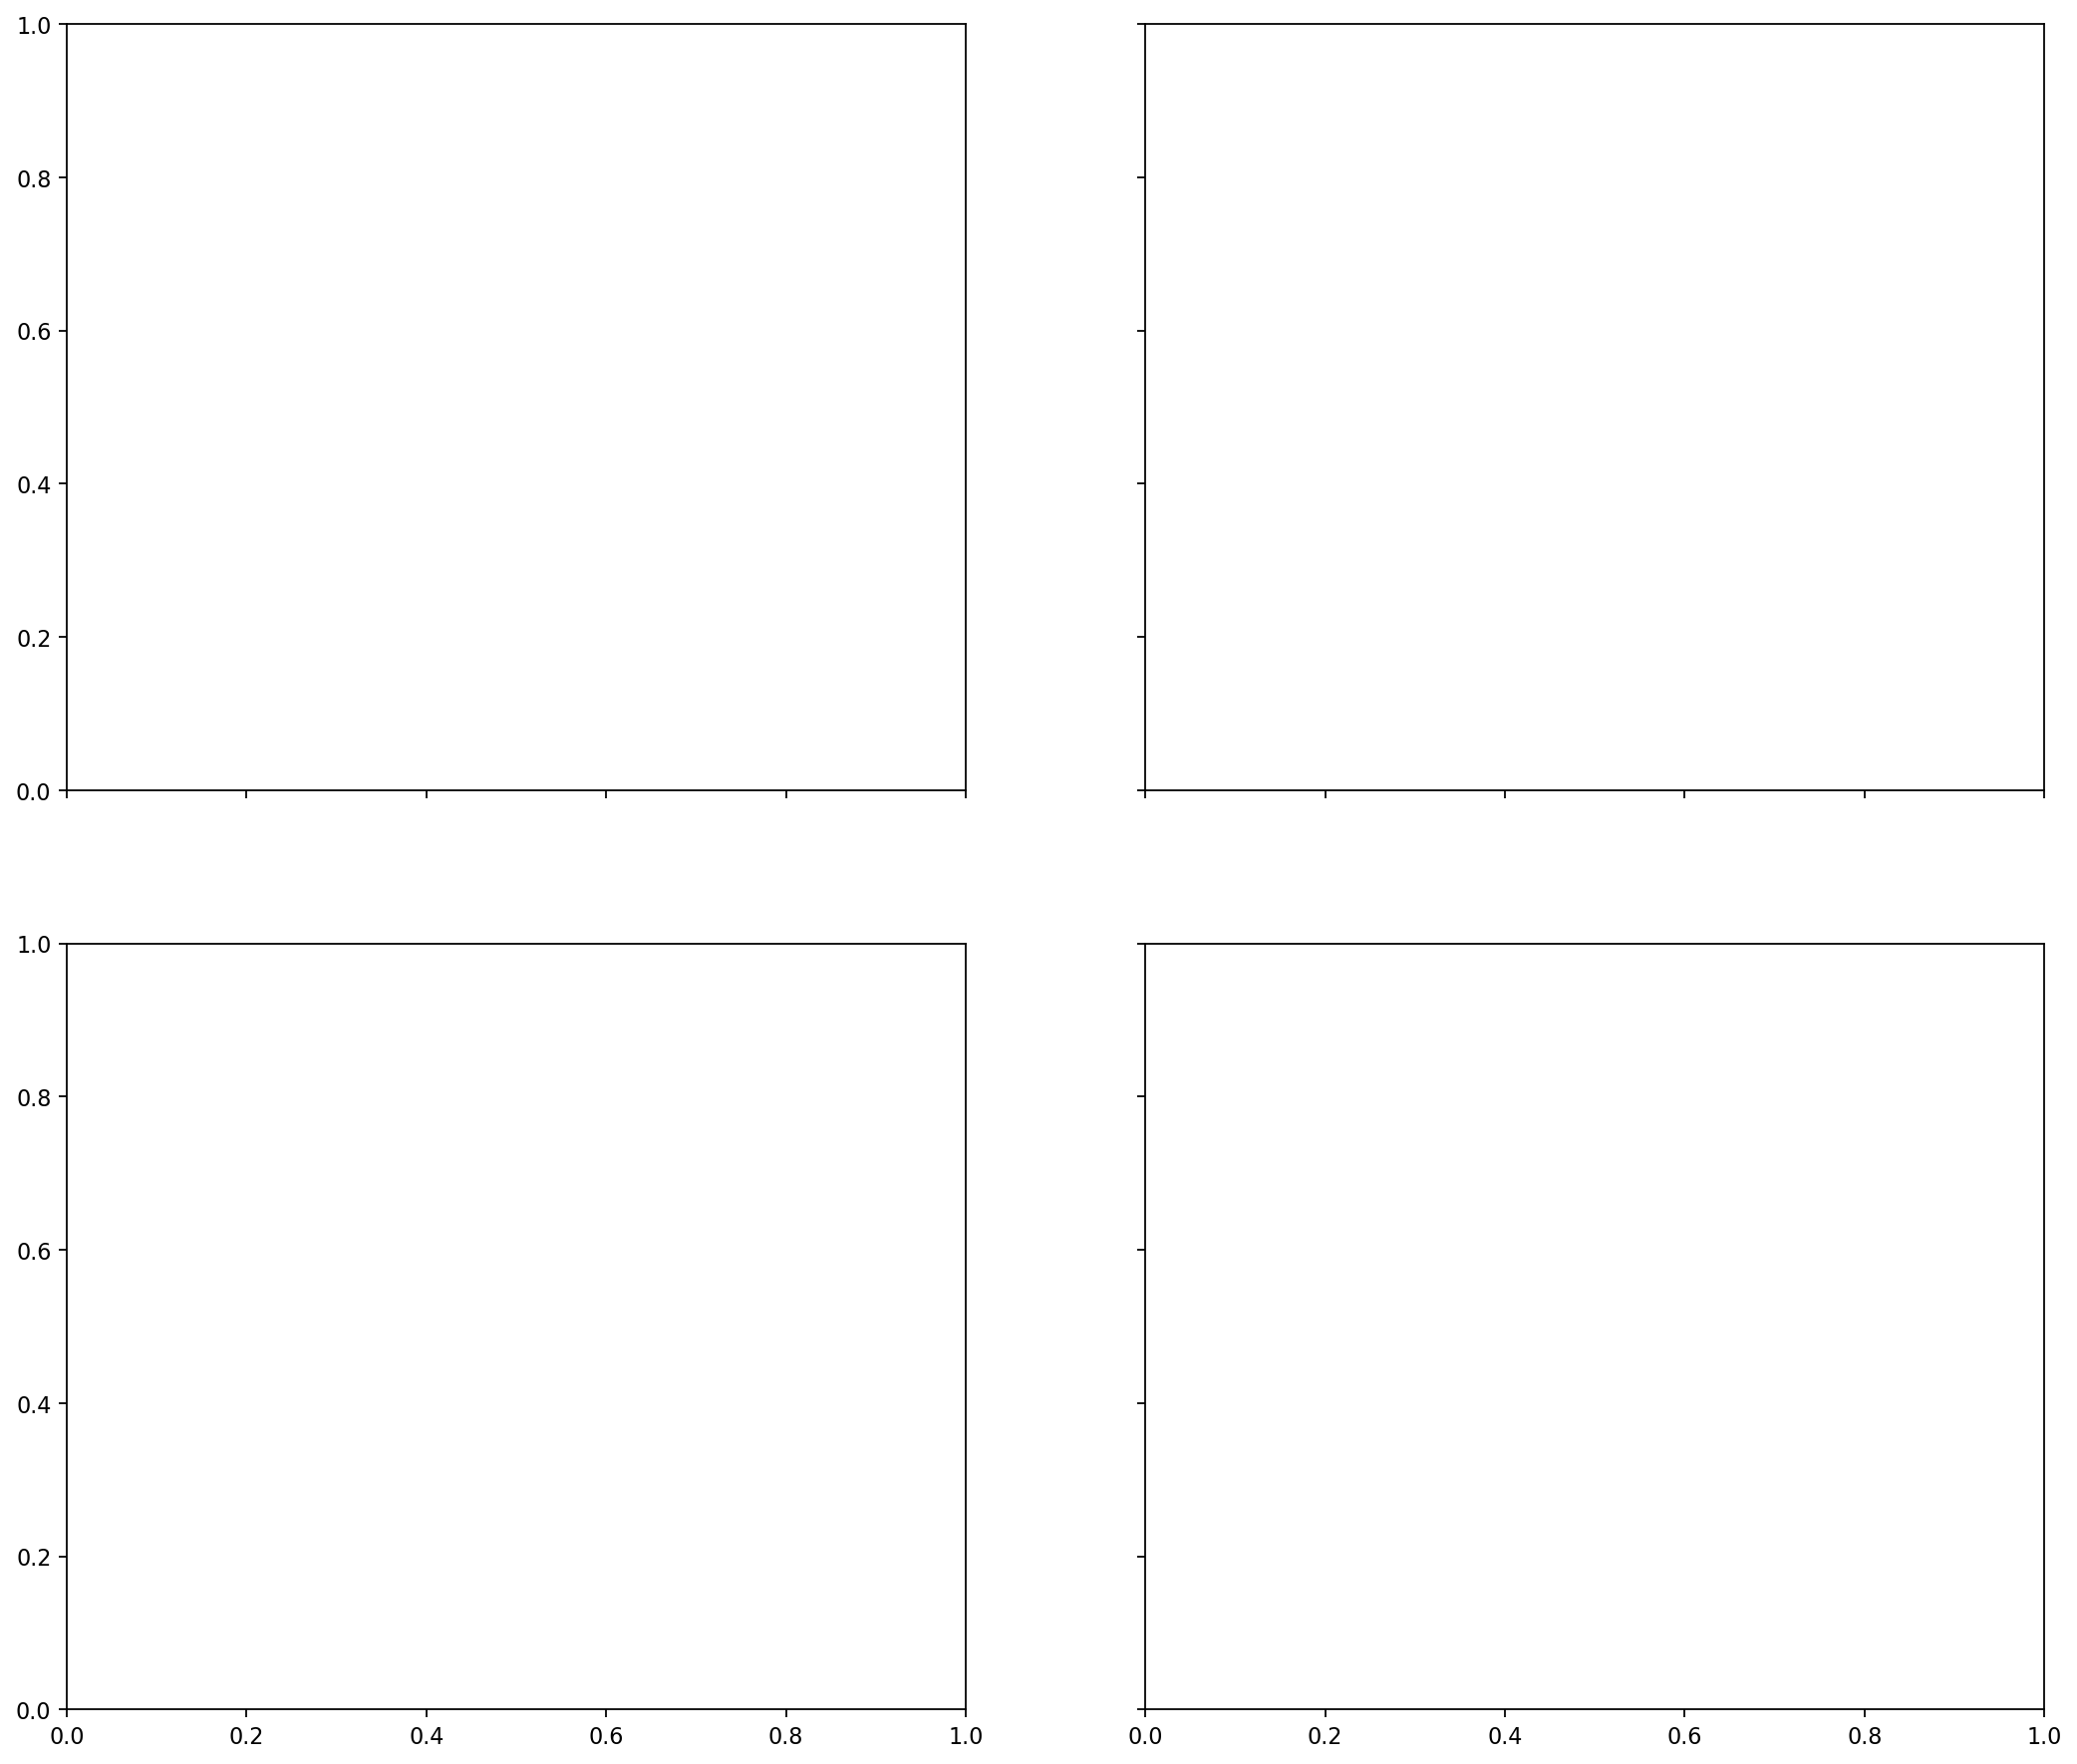

In [194]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_topic.loc[df_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

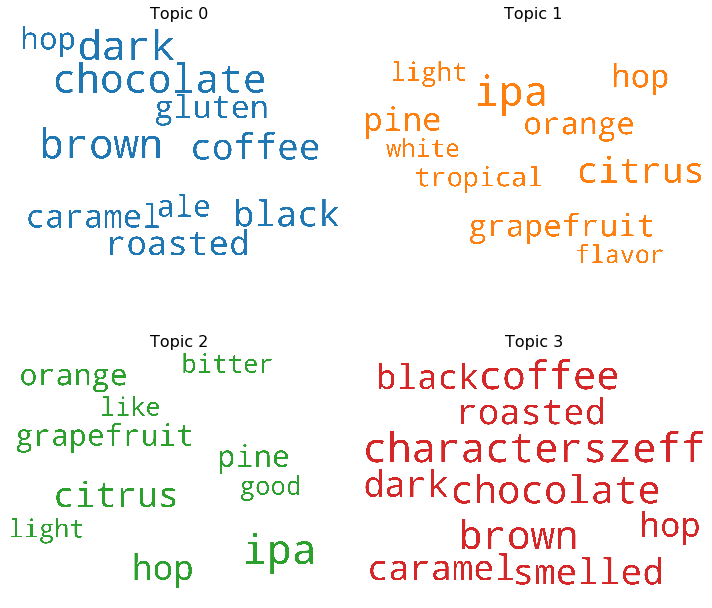

In [209]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
#                   max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_tfidf.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [212]:
wc = WordCloud(background_color='white', stopwords=stop_words, width=1600,
               height=900, colormap=matplotlib.cm.inferno).generate(lda_model_tfidf.show_topics(formatted=False))

# wc.generate(topics)

plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

TypeError: expected string or bytes-like object